## 1. Ingest and Access Data 

using SQLalchemy to ingest our data from our postgres database into a dataframe

In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
from pyspark.sql import SparkSession
# Database connection parameters
db_host = 'database-1.cxoaueie6ybk.us-east-2.rds.amazonaws.com'
db_port = 5432
db_name = 'postgres'
db_user = 'root'
db_password = 'irODJyh3LQpE0V3OcE3o'

# Create an engine to connect to the database
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Establish a connection to the database
conn = psycopg2.connect(
    host=db_host,
    port=db_port,
    dbname=db_name,
    user=db_user,
    password=db_password
)

### Accessing Data: Reading Data into Dataframe

In [2]:
# SQL query to fetch data
query = 'SELECT * FROM darwin'
# Load data into a DataFrame
df = pd.read_sql(query, con = conn)

df.head()

/tmp/ipykernel_30832/3926229495.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con = conn)


,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_pass,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,...,platform,train_length,estimated_time,source,actual_time,actual_time_class,is_delayed_arrival,is_delayed_departure,source_instance,estimated_time_minutes
0,202407038081744,P81744,2024-07-03,TD,CCRT,None,23:17:00,23:17:30,23:17:00,23:17:00,...,2,NaN,None,None,None,None,False,False,None,None
1,202407038097422,P97422,2024-07-03,TD,ALBNYPK,None,23:14:00,23:14:30,23:14:00,23:14:00,...,2,8.0,None,None,None,None,False,False,None,None
2,202407038097422,P97422,2024-07-03,TD,BEXLEY,None,23:16:30,23:17:30,23:17:00,23:17:00,...,2,8.0,None,None,None,None,False,False,None,None
3,202407037143658,G43658,2024-07-03,TD,SHAL341,None,23:29:00,23:32:00,None,None,...,None,NaN,None,None,None,None,False,False,None,None
4,202407037143658,G43658,2024-07-03,TD,SHALFD,None,23:34:00,23:35:30,None,None,...,None,NaN,None,None,None,None,False,False,None,None


#### Looking at an overview of the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392940 entries, 0 to 392939
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   route_id                392940 non-null  object 
 1   unique_id               392940 non-null  object 
 2   service_start_date      392940 non-null  object 
 3   update_origin           382647 non-null  object 
 4   train_platform          392940 non-null  object 
 5   working_time_pass       0 non-null       object 
 6   working_time_arrival    392940 non-null  object 
 7   working_time_departure  392940 non-null  object 
 8   planned_time_arrival    355969 non-null  object 
 9   planned_time_departure  354545 non-null  object 
 10  actual_arrival_time     327820 non-null  object 
 11  actual_departure_time   363802 non-null  object 
 12  platform                368833 non-null  object 
 13  train_length            139660 non-null  float64
 14  estimated_time      

## 2. Data Cleaning and Pre-processing

#### Dropping unnecessary columns

In [4]:
df = df.drop(['working_time_pass','estimated_time','source','actual_time','actual_time_class',
              'source_instance','estimated_time_minutes','working_time_arrival','working_time_departure'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392940 entries, 0 to 392939
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   route_id                392940 non-null  object 
 1   unique_id               392940 non-null  object 
 2   service_start_date      392940 non-null  object 
 3   update_origin           382647 non-null  object 
 4   train_platform          392940 non-null  object 
 5   planned_time_arrival    355969 non-null  object 
 6   planned_time_departure  354545 non-null  object 
 7   actual_arrival_time     327820 non-null  object 
 8   actual_departure_time   363802 non-null  object 
 9   platform                368833 non-null  object 
 10  train_length            139660 non-null  float64
 11  is_delayed_arrival      392940 non-null  bool   
 12  is_delayed_departure    392940 non-null  bool   
dtypes: bool(2), float64(1), object(10)
memory usage: 33.7+ MB


#### Checking for duplicate data in the data set and dropping thhem

In [5]:
df.duplicated().sum()

16026

In [6]:
df = df.drop_duplicates()
df.duplicated().sum()

0

#### Reading in a reference csv that helps to find the station names for every route, then drop all unnecessary columns

In [7]:
df2 = pd.read_csv("./Data/RailReferences.csv")
df2.head()

,AtcoCode,TiplocCode,CrsCode,StationName,StationNameLang,GridType,Easting,Northing,CreationDateTime,ModificationDateTime,RevisionNumber,Modification
0,9100PENZNCE,PENZNCE,PNZ,Penzance Rail Station,NaN,U,147588,30599,2003-11-04T00:00:00,2011-09-30T14:47:28,2,rev
1,9100STIVES,STIVES,SIV,St Ives (Cornwall) Rail Station,NaN,U,151947,40127,2005-04-04T00:00:00,2011-09-30T14:47:28,4,rev
2,9100CARBISB,CARBISB,CBB,Carbis Bay Rail Station,NaN,U,152930,38745,2003-11-04T00:00:00,2011-09-30T14:47:28,5,rev
3,9100STERTH,STERTH,SER,St Erth Rail Station,NaN,U,154150,35730,2003-11-04T00:00:00,2007-02-13T17:06:21,3,rev
4,9100LELANTS,LELANTS,LTS,Lelant Saltings Rail Station,NaN,U,154430,36640,2003-11-04T00:00:00,2011-09-30T14:47:28,2,rev


In [8]:
df2 = df2.drop(["StationNameLang","GridType","AtcoCode","Modification","CreationDateTime","ModificationDateTime","RevisionNumber","CrsCode"],axis=1)
df2

,TiplocCode,StationName,Easting,Northing
0,PENZNCE,Penzance Rail Station,147588,30599
1,STIVES,St Ives (Cornwall) Rail Station,151947,40127
2,CARBISB,Carbis Bay Rail Station,152930,38745
3,STERTH,St Erth Rail Station,154150,35730
4,LELANTS,Lelant Saltings Rail Station,154430,36640
...,...,...,...,...
2623,SMRLYTN,Somerleyton Rail Station,647930,296530
2624,OULTNBS,Oulton Broad South Rail Station,651920,292205
2625,YARMTH,Great Yarmouth Rail Station,652000,308100
2626,OULTNBN,Oulton Broad North Rail Station,652420,293140


#### Merging the rail reference dataframe and main dataframe to show station name, easting, and northing for every datapoint.

In [9]:
merged_df = pd.merge(df, df2, left_on='train_platform', right_on='TiplocCode', how='left')

#### Dropping the tiplocCode column as it was redundant with the added information

In [10]:
df = merged_df.drop(["TiplocCode"],axis = 1)

#### Showing Dataframe after merging

In [11]:
df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,train_length,is_delayed_arrival,is_delayed_departure,StationName,Easting,Northing
0,202407038081744,P81744,2024-07-03,TD,CCRT,23:17:00,23:17:00,None,23:17:00,2,NaN,False,False,Cathcart Rail Station,258460.0,660580.0
1,202407038097422,P97422,2024-07-03,TD,ALBNYPK,23:14:00,23:14:00,None,None,2,8.0,False,False,Albany Park Rail Station,547855.0,172860.0
2,202407038097422,P97422,2024-07-03,TD,BEXLEY,23:17:00,23:17:00,23:18:00,23:19:00,2,8.0,False,False,Bexley Rail Station,549380.0,173435.0
3,202407037143658,G43658,2024-07-03,TD,SHAL341,None,None,23:30:00,23:31:00,None,NaN,False,False,NaN,NaN,NaN
4,202407037143658,G43658,2024-07-03,TD,SHALFD,None,None,23:33:00,23:34:00,None,NaN,False,False,Shalford (Surrey) Rail Station,500200.0,147100.0


#### Checking for nulls

In [12]:
df.isna().sum()

route_id                       0
unique_id                      0
service_start_date             0
update_origin               8877
train_platform                 0
planned_time_arrival       36624
planned_time_departure     37796
actual_arrival_time        63731
actual_departure_time      27779
platform                   23542
train_length              241802
is_delayed_arrival             0
is_delayed_departure           0
StationName                28627
Easting                    28627
Northing                   28627
dtype: int64

#### Dropping the nulls in Easting and Northing before converting them to Latitude and Longitude

In [13]:
df = df.dropna(subset=['Easting', 'Northing'])

#### Installing bng_latlon package to convert northing and easting to latitude and longitude


In [14]:
# !pip install bng_latlon

#### Creating a user defined function to calculate those values and writing to new columns with the longitude and latitude values

In [15]:
from bng_latlon import OSGB36toWGS84
def latlong(df):
    lat_long = []
    for i in range(len(df)):
        lat_long.append( OSGB36toWGS84(df[i][0],df[i][1]) )
    return lat_long
df['Easting'] = df['Easting'].astype('int64')
df['Northing'] = df['Northing'].astype('int64')
df1 = df [['Easting','Northing']]
values = (df1.values)
lat_long = latlong(values)
#Writing to dataframe
lat = []
long = []
for i in range(len(lat_long)):
    lat.append(lat_long[i][0])
    long.append(lat_long[i][1])
    
df['Latitude'] = lat
df['Longitude'] = long

#### Creating a new dataframe that drops all null values and checking the amount of data left.

In [16]:
na_df = df.dropna()

In [17]:
#getting an overview of the amount of rows dropped and if we should continue with the null dropped dataset
na_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99029 entries, 2 to 376912
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                99029 non-null  object 
 1   unique_id               99029 non-null  object 
 2   service_start_date      99029 non-null  object 
 3   update_origin           99029 non-null  object 
 4   train_platform          99029 non-null  object 
 5   planned_time_arrival    99029 non-null  object 
 6   planned_time_departure  99029 non-null  object 
 7   actual_arrival_time     99029 non-null  object 
 8   actual_departure_time   99029 non-null  object 
 9   platform                99029 non-null  object 
 10  train_length            99029 non-null  float64
 11  is_delayed_arrival      99029 non-null  bool   
 12  is_delayed_departure    99029 non-null  bool   
 13  StationName             99029 non-null  object 
 14  Easting                 99029 non-nul

After dropping data we are left with ~100,000 datapoints which is ~25% of our total data. We think this is significant enough for our analysis.

In [18]:
df = na_df

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99029 entries, 2 to 376912
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                99029 non-null  object 
 1   unique_id               99029 non-null  object 
 2   service_start_date      99029 non-null  object 
 3   update_origin           99029 non-null  object 
 4   train_platform          99029 non-null  object 
 5   planned_time_arrival    99029 non-null  object 
 6   planned_time_departure  99029 non-null  object 
 7   actual_arrival_time     99029 non-null  object 
 8   actual_departure_time   99029 non-null  object 
 9   platform                99029 non-null  object 
 10  train_length            99029 non-null  float64
 11  is_delayed_arrival      99029 non-null  bool   
 12  is_delayed_departure    99029 non-null  bool   
 13  StationName             99029 non-null  object 
 14  Easting                 99029 non-nul

#### Changing all dates or time columns to the correct data type.

In [20]:
from datetime import time
#changing the columns with dates to datetime objects
df['service_start_date'] = pd.to_datetime(df['service_start_date'])
df['planned_time_arrival'] = pd.to_datetime(df['planned_time_arrival'], format='%H:%M:%S').dt.time
df['planned_time_departure'] = pd.to_datetime(df['planned_time_departure'], format='%H:%M:%S').dt.time
df['actual_arrival_time'] = pd.to_datetime(df['actual_arrival_time'], format='%H:%M:%S').dt.time
df['actual_departure_time'] = pd.to_datetime(df['actual_departure_time'], format='%H:%M:%S').dt.time

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99029 entries, 2 to 376912
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   route_id                99029 non-null  object        
 1   unique_id               99029 non-null  object        
 2   service_start_date      99029 non-null  datetime64[ns]
 3   update_origin           99029 non-null  object        
 4   train_platform          99029 non-null  object        
 5   planned_time_arrival    99029 non-null  object        
 6   planned_time_departure  99029 non-null  object        
 7   actual_arrival_time     99029 non-null  object        
 8   actual_departure_time   99029 non-null  object        
 9   platform                99029 non-null  object        
 10  train_length            99029 non-null  float64       
 11  is_delayed_arrival      99029 non-null  bool          
 12  is_delayed_departure    99029 non-null  bool 

#### Converting all time columns to datetime objects with the service_start_date as the date

In [21]:
from datetime import datetime
from datetime import timedelta
df['actual_departure_time'] = df.apply(lambda row: datetime.combine(row['service_start_date'].date(), row['actual_departure_time']), axis=1)
df['planned_time_departure'] = df.apply(lambda row: datetime.combine(row['service_start_date'].date(), row['planned_time_departure']), axis=1)
df['planned_time_arrival'] = df.apply(lambda row: datetime.combine(row['service_start_date'].date(), row['planned_time_arrival']), axis=1)
df['actual_arrival_time'] = df.apply(lambda row: datetime.combine(row['service_start_date'].date(), row['actual_arrival_time']), axis=1)

In [22]:
df.dtypes

route_id                          object
unique_id                         object
service_start_date        datetime64[ns]
update_origin                     object
train_platform                    object
planned_time_arrival      datetime64[ns]
planned_time_departure    datetime64[ns]
actual_arrival_time       datetime64[ns]
actual_departure_time     datetime64[ns]
platform                          object
train_length                     float64
is_delayed_arrival                  bool
is_delayed_departure                bool
StationName                       object
Easting                            int64
Northing                           int64
Latitude                         float64
Longitude                        float64
dtype: object

#### Creating user defined functions to check for cases of dates arrival times or actual departure times taking place the day after the service start day, and add a day to the column values.

In [23]:
from datetime import datetime
from datetime import timedelta
#Adding service_start_date to time objects to get a datetime for every time column
def change_actual_departure(row):
    #Check if times occur after the initial service start day and correcting their date to the next day
    if row['actual_departure_time'] < row['planned_time_departure']: 
        return row['actual_departure_time'] + timedelta(days=1)
    return row['actual_departure_time']

def change_arrival(row):
    #Check if times occur after the initial service start day and correcting their date to the next day
    if row['actual_arrival_time'] < row['planned_time_arrival']: 
        return row['actual_arrival_time'] + timedelta(days=1)
    return row['actual_arrival_time']
        

In [24]:
df['actual_departure_time'] = df.apply(change_actual_departure, axis=1)
df['actual_arrival_time'] = df.apply(change_arrival, axis=1)

#### Creating a calculated time difference column to further calculate delayed departure and arrival minutes

In [25]:
from datetime import time, timedelta
df['actual_vs_planned_arrival'] = df['actual_arrival_time'] - df['planned_time_arrival']

df['actual_vs_planned_arrival']

2        0 days 00:01:00
25       0 days 00:00:00
37       0 days 00:01:00
38       0 days 00:01:00
44       0 days 00:00:00
               ...      
376897   0 days 00:00:00
376907   0 days 00:00:00
376910   0 days 00:02:00
376911   0 days 00:00:00
376912   0 days 00:00:00
Name: actual_vs_planned_arrival, Length: 99029, dtype: timedelta64[ns]

In [26]:
from datetime import time, timedelta

df['actual_vs_planned_departure'] = df['actual_departure_time'] - df['planned_time_departure']

#### Creating delayed arrival and delayed departure minutes column

In [27]:
df['delayed_arrival_min'] = (df['actual_vs_planned_arrival'].dt.total_seconds() / 60)

df['delayed_departure_min'] = (df['actual_vs_planned_departure'].dt.total_seconds() / 60)

Function to calculate origin and destination for each trip

In [28]:
def calculate_origin_destination(group):
    origin = group.iloc[0]['StationName']
    destination = group.iloc[-1]['StationName']
    return pd.Series({
        'Origin': origin,
        'Destination': destination
    })
# Group by route_id, unique_id, and service_start_date, then apply the function to calculate origin and destination
origin_destination = df.groupby(['route_id', 'unique_id', 'service_start_date']).apply(calculate_origin_destination).reset_index()
#Joining into original dataframe
df = df.merge(origin_destination, on=['route_id', 'unique_id', 'service_start_date'], how='left')

#### Getting an overview of the data before exporting to csv file.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99029 entries, 0 to 99028
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   route_id                     99029 non-null  object         
 1   unique_id                    99029 non-null  object         
 2   service_start_date           99029 non-null  datetime64[ns] 
 3   update_origin                99029 non-null  object         
 4   train_platform               99029 non-null  object         
 5   planned_time_arrival         99029 non-null  datetime64[ns] 
 6   planned_time_departure       99029 non-null  datetime64[ns] 
 7   actual_arrival_time          99029 non-null  datetime64[ns] 
 8   actual_departure_time        99029 non-null  datetime64[ns] 
 9   platform                     99029 non-null  object         
 10  train_length                 99029 non-null  float64        
 11  is_delayed_arrival          

In [30]:
df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,...,Easting,Northing,Latitude,Longitude,actual_vs_planned_arrival,actual_vs_planned_departure,delayed_arrival_min,delayed_departure_min,Origin,Destination
0,202407038097422,P97422,2024-07-03,TD,BEXLEY,2024-07-03 23:17:00,2024-07-03 23:17:00,2024-07-03 23:18:00,2024-07-03 23:19:00,2,...,549380,173435,51.440218,0.147903,0 days 00:01:00,0 days 00:02:00,1.0,2.0,Bexley Rail Station,Bexley Rail Station
1,202407037139898,G39898,2024-07-03,CIS,BOXHAWH,2024-07-03 23:18:00,2024-07-03 23:18:00,2024-07-03 23:18:00,2024-07-03 23:18:00,1,...,516744,151865,51.254010,-0.328490,0 days 00:00:00,0 days 00:00:00,0.0,0.0,Box Hill & Westhumble Rail Station,Box Hill & Westhumble Rail Station
2,202407037154196,G54196,2024-07-03,CIS,HYWRDSH,2024-07-03 23:16:00,2024-07-03 23:17:00,2024-07-03 23:17:00,2024-07-03 23:18:00,3,...,533045,124630,51.005680,-0.105078,0 days 00:01:00,0 days 00:01:00,1.0,1.0,Haywards Heath Rail Station,Three Bridges Rail Station
3,202407037154196,G54196,2024-07-03,CIS,THBDGS,2024-07-03 23:28:00,2024-07-03 23:29:00,2024-07-03 23:29:00,2024-07-03 23:30:00,4,...,528800,136900,51.116922,-0.161184,0 days 00:01:00,0 days 00:01:00,1.0,1.0,Haywards Heath Rail Station,Three Bridges Rail Station
4,202407037150851,G50851,2024-07-03,TD,HRPNDN,2024-07-03 23:22:00,2024-07-03 23:22:00,2024-07-03 23:22:00,2024-07-03 23:22:00,2,...,513735,214175,51.814643,-0.351481,0 days 00:00:00,0 days 00:00:00,0.0,0.0,Harpenden Rail Station,Luton Airport Parkway Rail Station


Converting the dataframe into a csv file to be exported into other programs like PowerBI

In [31]:
df.to_csv('./Data/cleanRailData.csv', index=False)

## 3. Data Visualization

In [32]:
#importing plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#### Distribution of Categorical and Numerical Data


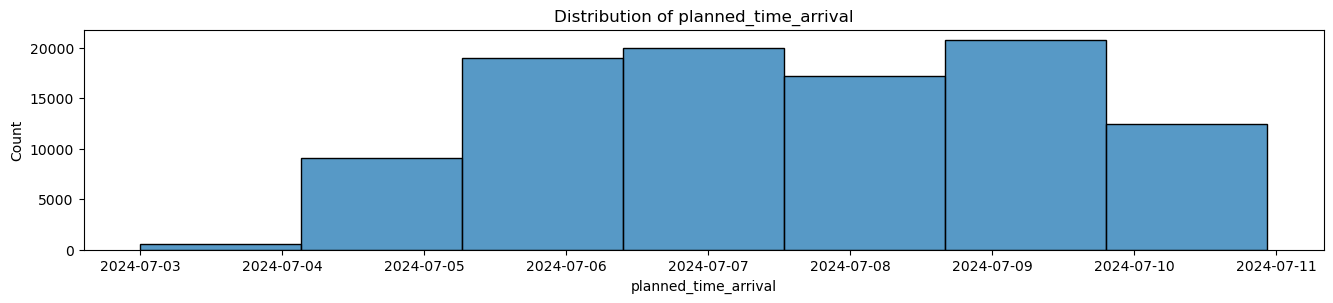

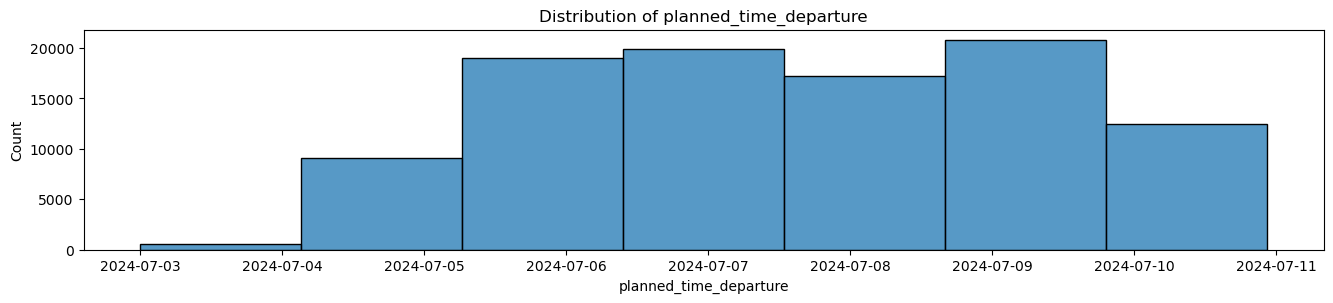

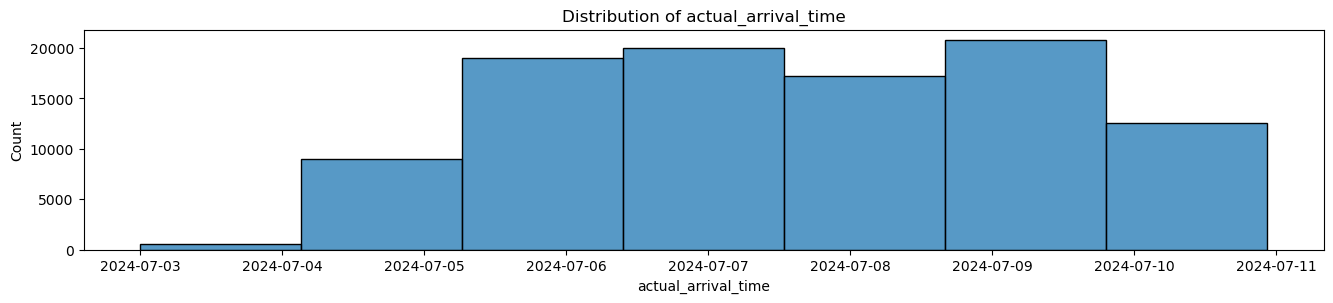

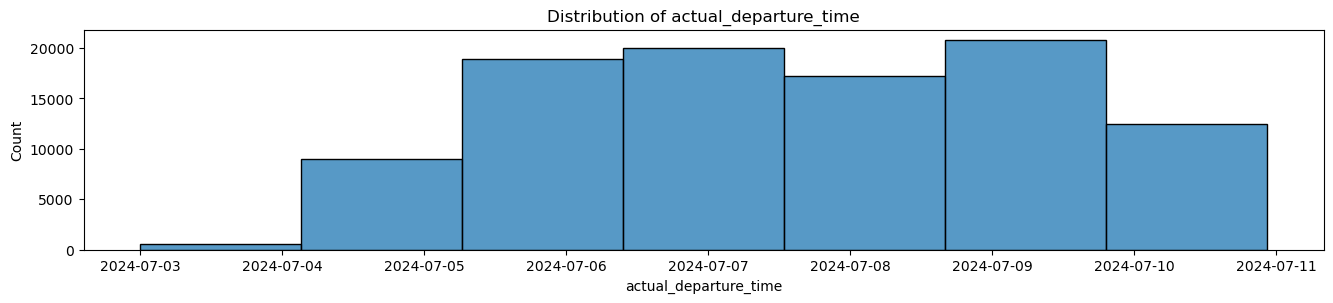

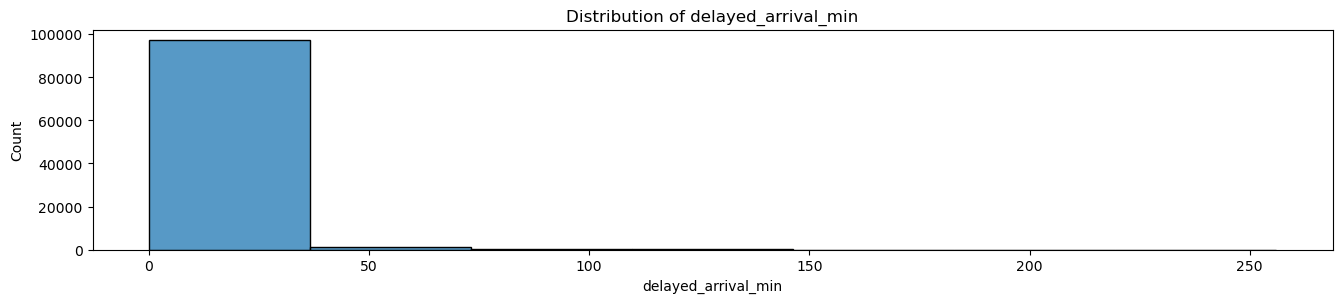

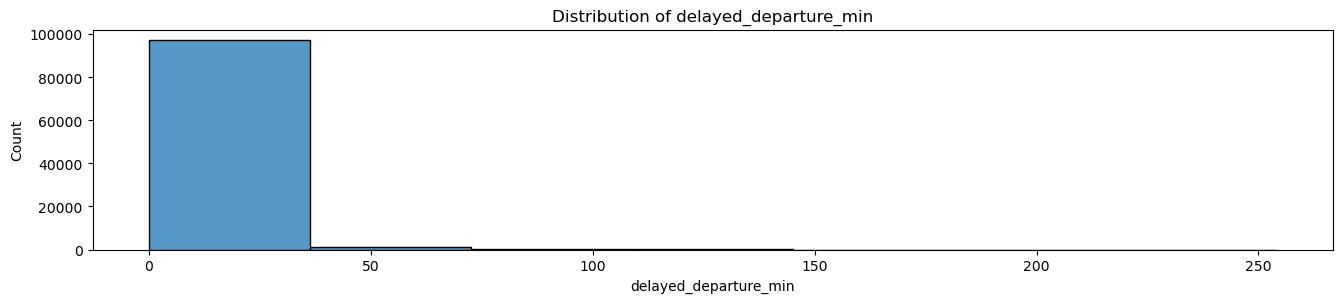

In [33]:

numerical_cols = ['planned_time_arrival', 'planned_time_departure', 'actual_arrival_time', 'actual_departure_time', 
                  'delayed_arrival_min', 'delayed_departure_min']
subplot_index = 1
for col in numerical_cols:
    plt.figure(figsize=(16, 20))
    plt.subplot(len(numerical_cols),1,subplot_index)
    sns.histplot(df[col], bins=7)
    plt.title(f'Distribution of {col}')
    plt.show()

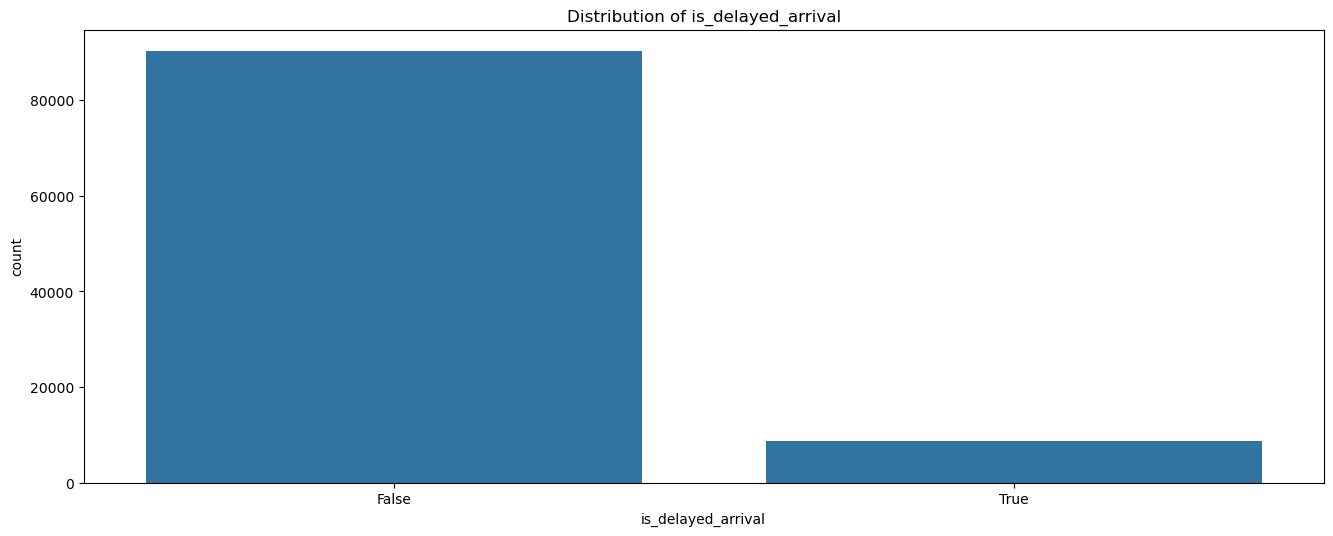

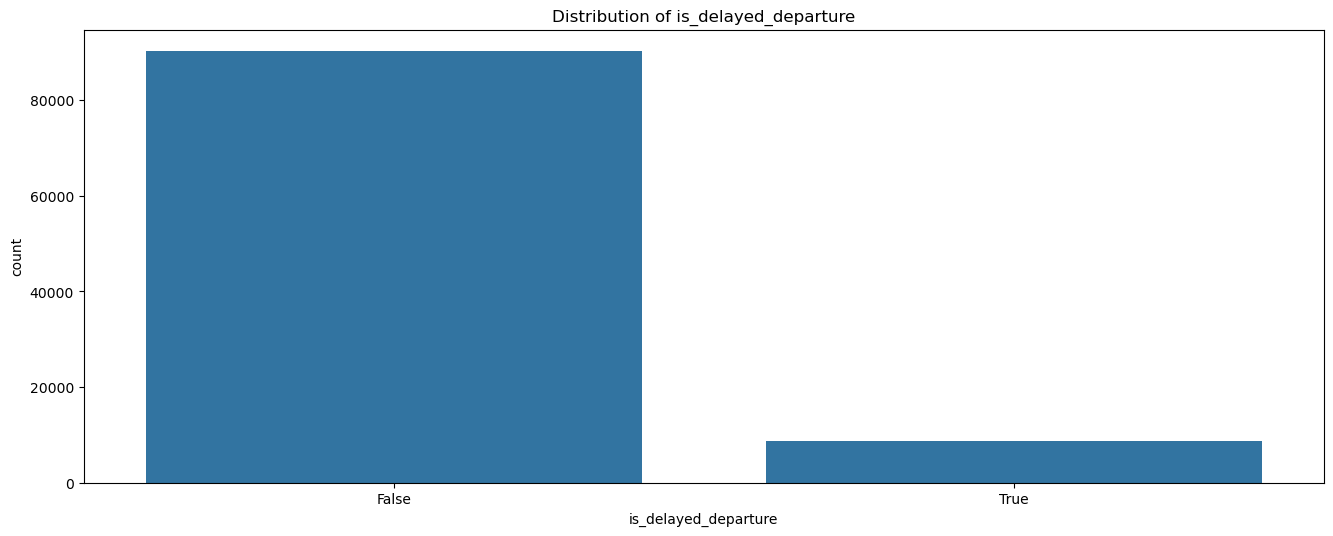

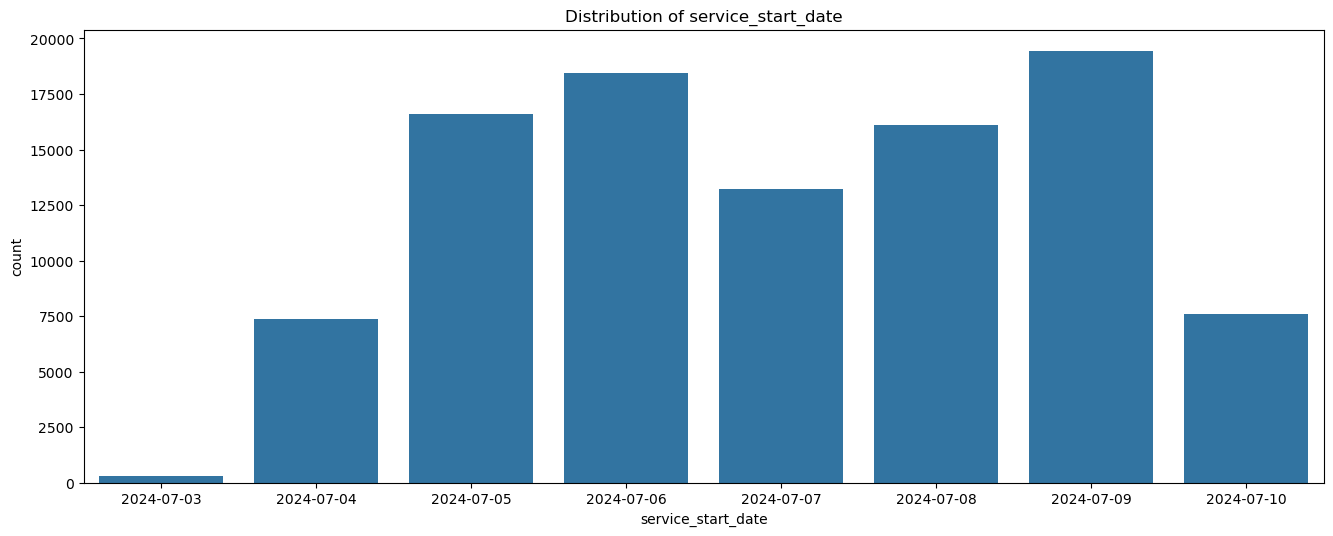

In [34]:
categorical_cols = ['is_delayed_arrival', 'is_delayed_departure','service_start_date']
#histograms for categorical variables
subplot_index = 1
for col in categorical_cols:
    plt.figure(figsize=(16, 20))
    plt.subplot(len(categorical_cols),1,subplot_index)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.show()

#### What is the distribution of delays in minutes?

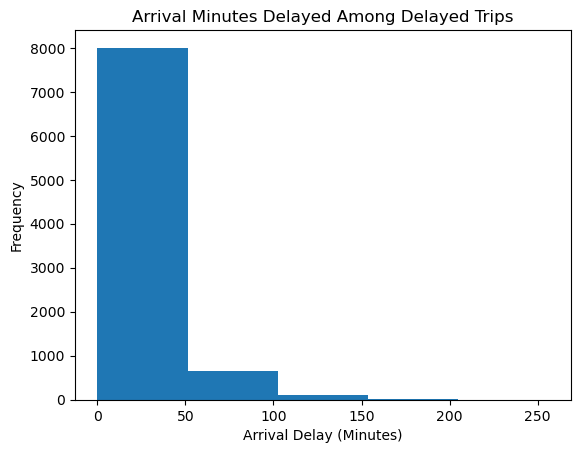

In [35]:
#creating a df with only delayed arrival trains
delayed_arrivals = df[df['is_delayed_arrival'] == True]
# Plotting the histogram using matplotlib
plt.hist(delayed_arrivals['delayed_arrival_min'], bins=5)

# Adding titles and labels
plt.title('Arrival Minutes Delayed Among Delayed Trips')
plt.xlabel('Arrival Delay (Minutes)')
plt.ylabel('Frequency')
plt.show()

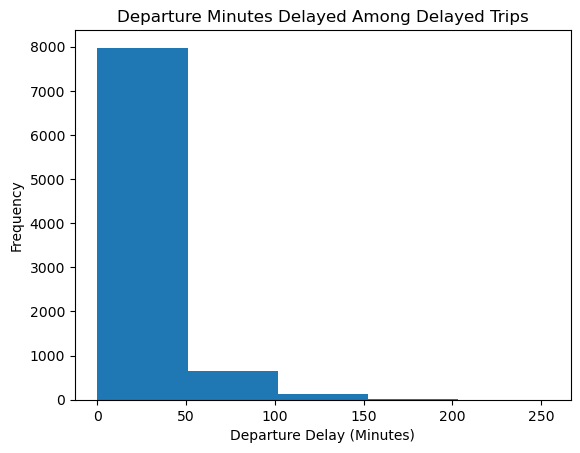

In [36]:
#creating a df with only delayed arriva trains
delayed_departures = df[df['is_delayed_departure'] == True]
# Plotting the histogram using matplotlib
plt.hist(delayed_arrivals['delayed_departure_min'], bins=5)

# Adding titles and labels
plt.title('Departure Minutes Delayed Among Delayed Trips')
plt.xlabel('Departure Delay (Minutes)')
plt.ylabel('Frequency')
plt.show()

#### Correlation Analysis among numerical data

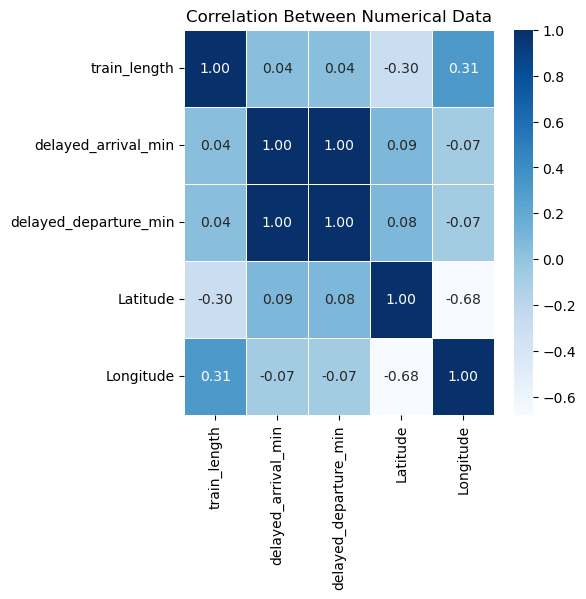

In [37]:
df1 = df[['train_length', 'delayed_arrival_min', 'delayed_departure_min', 'Latitude', 'Longitude']]
corr_matrix = df1.corr()
# Create a correlation heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Numerical Data')
plt.show()

We found an absolute correlation between arrival delay and departure delay and decided to make a scatter plot to visualize the impact of Departure Delay on Arrival time.

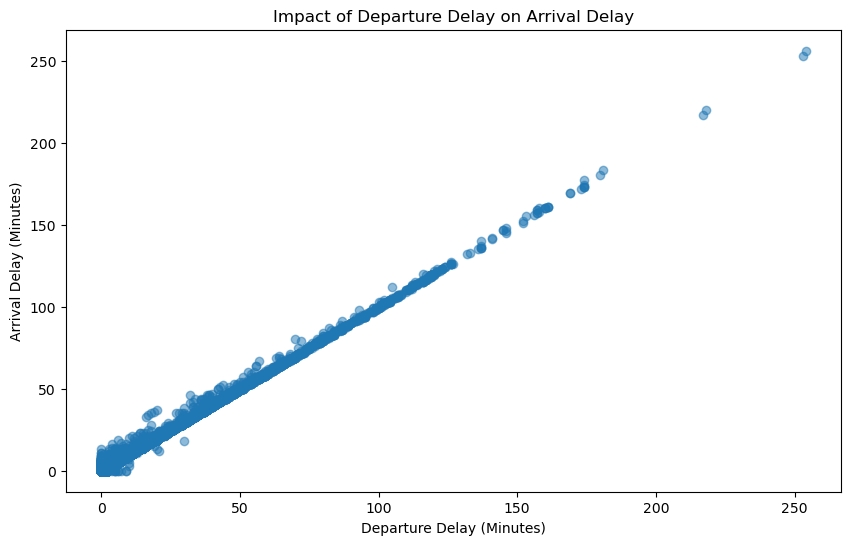

In [38]:
plt.figure(figsize=(10,6))
plt.scatter(df['delayed_departure_min'], df['delayed_arrival_min'], alpha=0.5)
plt.xlabel('Departure Delay (Minutes)')
plt.ylabel('Arrival Delay (Minutes)')
plt.title('Impact of Departure Delay on Arrival Delay')
plt.show()

This strong correlation of 1.00 shows that departure delay is significantly impacting the arrival time.